In [1]:
# Libraries
import numpy as np
from sklearn.metrics import *
import matplotlib.pyplot as plt
from tqdm import tqdm


from NaiveBayes import NB_clf
from LinearDiscriminantAnalysis import LDA_implemented




# Load data

In [2]:
train_data = np.load("data/fashion_train.npy")
X_train, y_train = train_data[:,:784], train_data[:,-1]

test_data = np.load("data/fashion_test.npy")
X_test, y_test = test_data[:,:784], test_data[:,-1]

N_CLASSES = len(np.unique(y_train))
CLOTHING_TYPES = {0: "T-shirt/top", 
                  1: "Trouser",
                  2: "Pullover",
                  3: "Dress",
                  4: "Shirt"}

CLOTHING_COLORS = {0: "darkorange", 
                   1: "lightseagreen",
                   2: "orangered",
                   3: "cornflowerblue",
                   4: "orchid"}

# Perform LDA

In [3]:
lda = LDA_implemented(4)
LDA_X_train = lda.fit_transform(X=X_train, y=y_train)
LDA_X_test = lda.transform(X_test)


LDA succesfully fitted and tranformed


# Naive Bayes
First we will show how to use our implementation of Naive Bayes

In [4]:
# Fit
nb_clf = NB_clf(bandwidth=0.5)
nb_clf.fit(LDA_X_train[:,:2],y_train)

# Predict
y_pred = nb_clf.predict(LDA_X_test[:,:2])

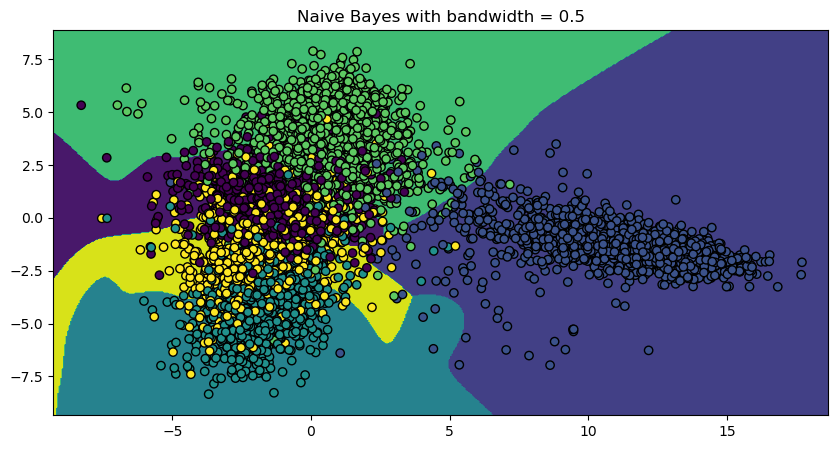

In [89]:
# We can also plot the decision regions

fig,ax = plt.subplots(nrows=1,ncols=1, figsize=(10,5))

# Courseness of contourplot.  
h = 0.1

x_min, x_max = np.min(LDA_X_train[:,0])-1, np.max(LDA_X_train[:,0]) + 1
y_min, y_max = np.min(LDA_X_train[:,1])-1, np.max(LDA_X_train[:,1]) + 1

xx,yy = np.meshgrid(np.arange(x_min, x_max, h),
                    np.arange(y_min, y_max, h))

Z = nb_clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

ax.contourf(xx,yy, Z)
ax.scatter(LDA_X_train[:,0],LDA_X_train[:,1], c=y_train, marker='o', edgecolor='black')
ax.set_xlim(xx.min(), xx.max());
ax.set_ylim(yy.min(), yy.max());
ax.set_title(f"Naive Bayes with bandwidth = 0.5");


### We would like to test the optimal bandwidth

To test, we train 16 naive bayes methods with differing bandwidths

In [9]:
F1_scores = []
bandwidths = np.linspace(0.05, 1.2, 16)

for bw in bandwidths:
    nbclf = NB_clf(bw)
    nbclf.fit(LDA_X_train[:,:2], y_train)
    predictions = nbclf.predict(LDA_X_test[:,:2])
    F1 = f1_score(y_test, predictions, average='macro')
    F1_scores.append(F1)

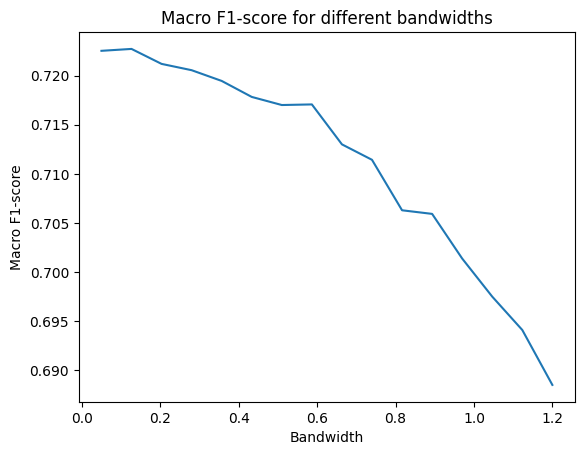

In [10]:
plt.plot(bandwidths, F1_scores)
plt.xlabel('Bandwidth')
plt.ylabel('Macro F1-score')
plt.title('Macro F1-score for different bandwidths');

On the basis of the plot above, a reasonable bandwidth could be 0.6, as this looks like an elbow point of the curve, i.e., the macro F1-score decreases faster after 0.6. Another important argument is that a lower bandwidth increases the risk of overfitting. In other words, the model generalizes better, when a higher value is chosen as the bandwidth. So 0.6 might be a tradeoff between high performance and a general model, that will also perform well on unknown test data.

To further test this, we also plot the decision boundaries of each model. 

100%|██████████| 3/3 [10:18<00:00, 206.23s/it]


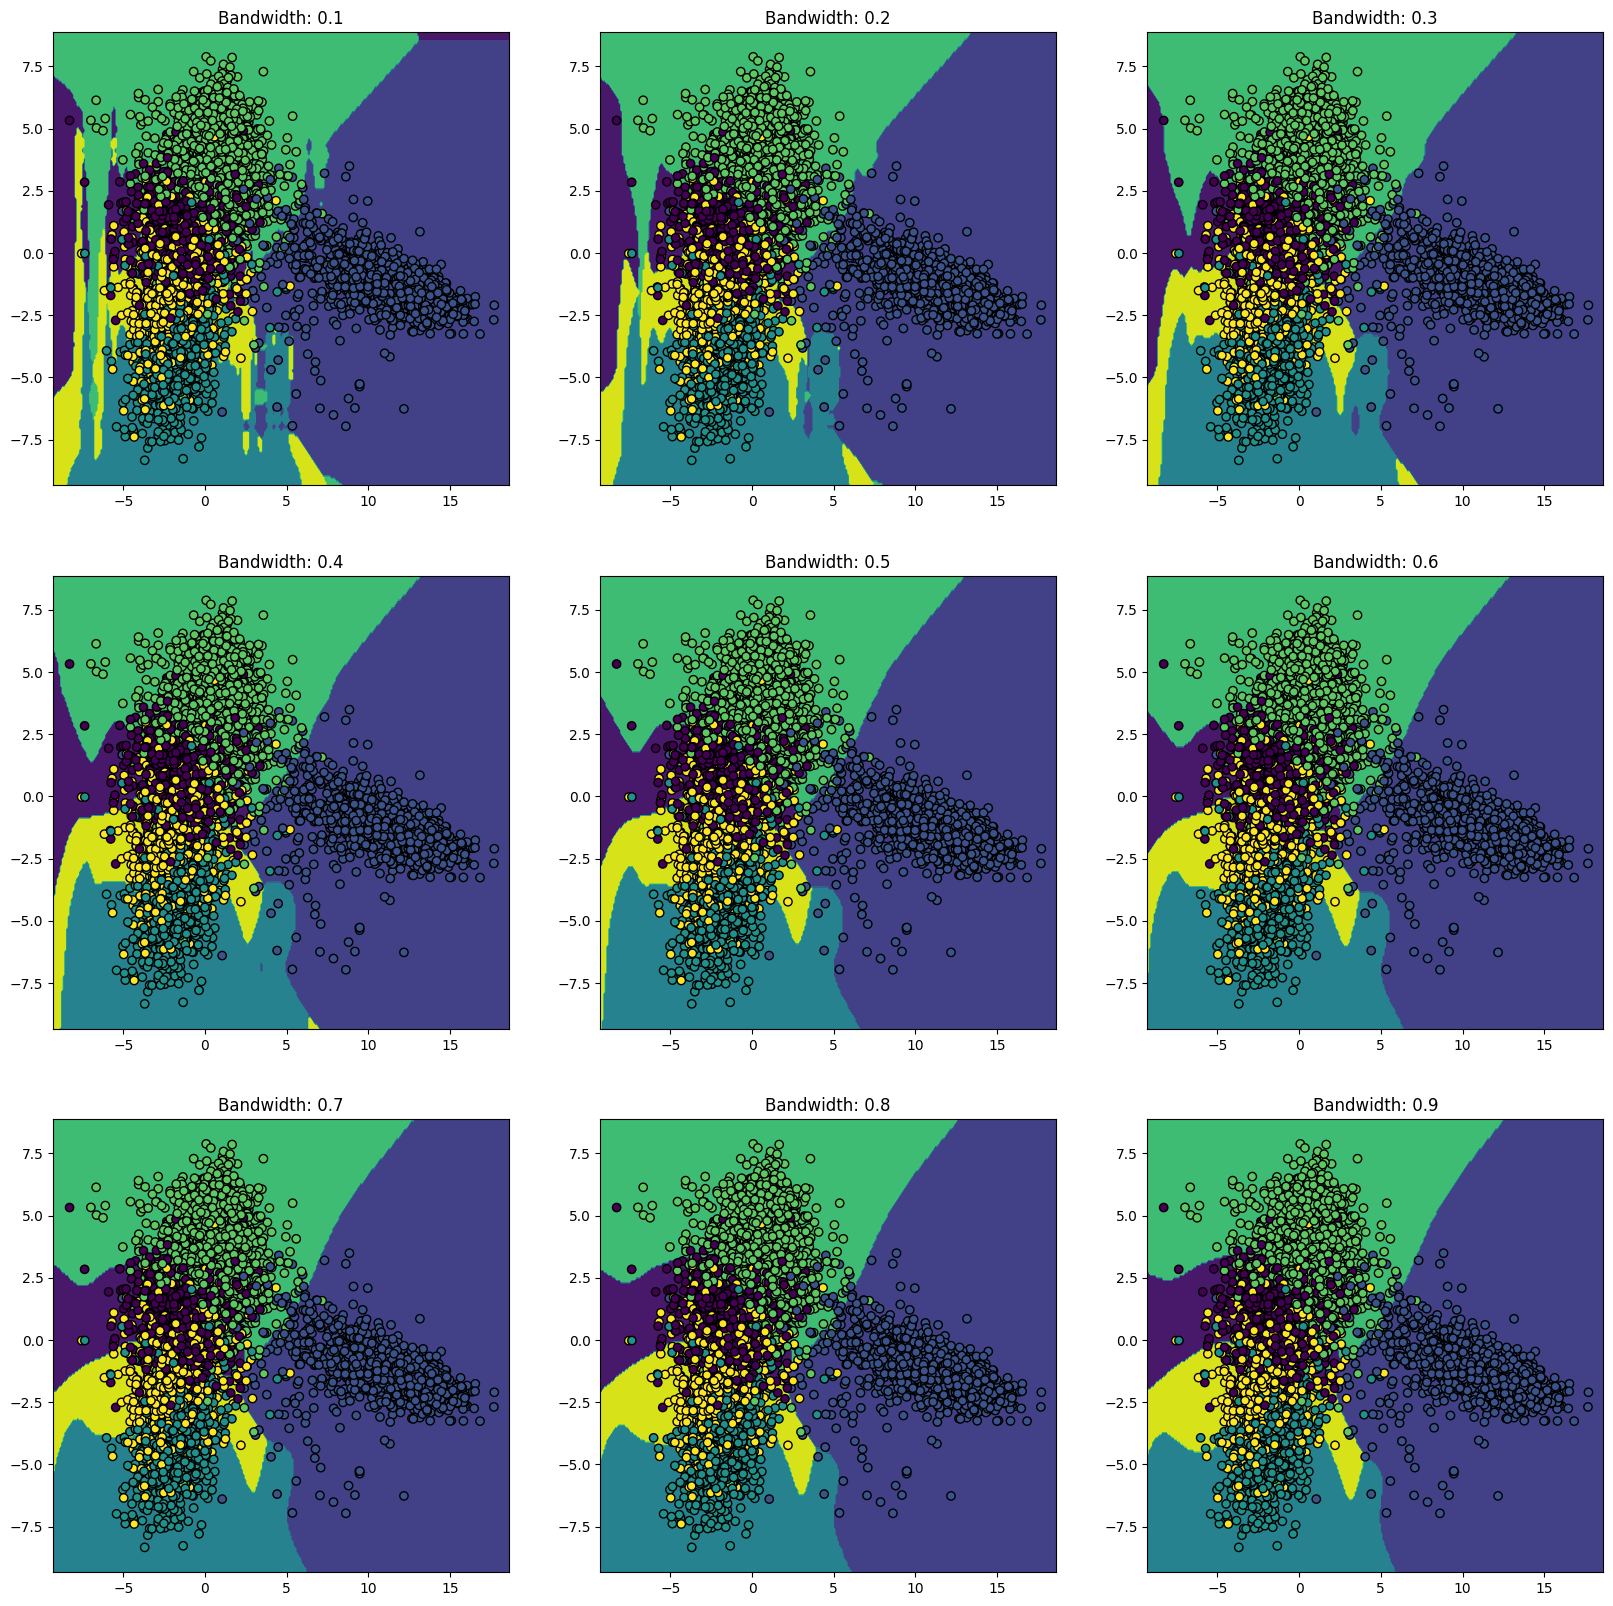

In [19]:
fig,ax = plt.subplots(nrows=3,ncols=3, figsize=(20,20))

bandwidths = np.linspace(0.1, 0.9, 9).reshape(3,3)


h = 0.1

x_min, x_max = np.min(LDA_X_train[:,0])-1, np.max(LDA_X_train[:,0]) + 1
y_min, y_max = np.min(LDA_X_train[:,1])-1, np.max(LDA_X_train[:,1]) + 1

xx,yy = np.meshgrid(np.arange(x_min, x_max, h),
                    np.arange(y_min, y_max, h))


for i in range(3):
    for j in tqdm(range(3)):
        nbclf = NB_clf(bandwidth=bandwidths[i,j])
        nbclf.fit(LDA_X_train[:,:2], y_train)
        Z = nbclf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        ax[i,j].contourf(xx,yy, Z)
        ax[i,j].scatter(LDA_X_train[:,0],LDA_X_train[:,1], c=y_train, marker='o', edgecolor='black')
        ax[i,j].set_xlim(xx.min(), xx.max());
        ax[i,j].set_ylim(yy.min(), yy.max());
        ax[i,j].set_title(f"Bandwidth: {round(bandwidths[i,j],2)}")



We see that the bandwidth of 0.6 would indeed be fitting. Thus we choose this.

# Performance metrics of Naive Bayes Implementation

In [11]:
# creating class instance with bandwidth 0.6
nbclf_chosen = NB_clf(0.6)

# training the classifier
nbclf_chosen.fit(LDA_X_train[:,:2], y_train)

# making predictions on the test data and retrieving the performance
predictions = nbclf_chosen.predict(LDA_X_test[:,:2])
print(classification_report(y_test, predictions, target_names=CLOTHING_TYPES.values()))

              precision    recall  f1-score   support

 T-shirt/top       0.58      0.77      0.66      1000
     Trouser       0.98      0.95      0.96      1000
    Pullover       0.71      0.79      0.75      1000
       Dress       0.81      0.79      0.80      1000
       Shirt       0.54      0.33      0.41      1000

    accuracy                           0.73      5000
   macro avg       0.72      0.73      0.72      5000
weighted avg       0.72      0.73      0.72      5000



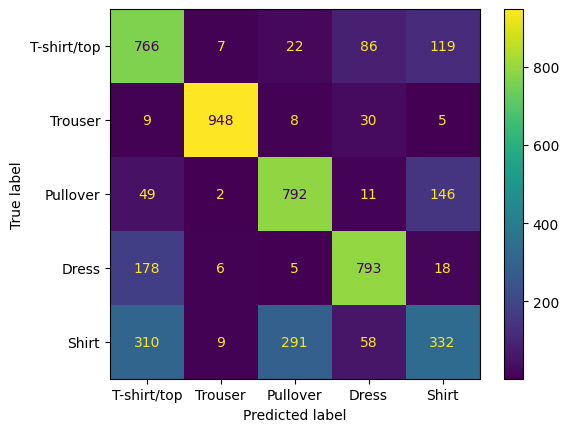

In [12]:
# visualizing the performance of the Naive Bayes classifier with a confusion matrix
cm = confusion_matrix(y_true=y_test, y_pred=predictions, labels=list(CLOTHING_TYPES.keys()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLOTHING_TYPES.values())
ax = disp.plot()
ax.ax_.grid(False)

From the above we can see that naive bayes is good at differing trousers from the rest of the clothes. It has a hard time with shirts, which it mixes up with a pullover and a t-shirt/top. This makes sense as we remember from the EDA.

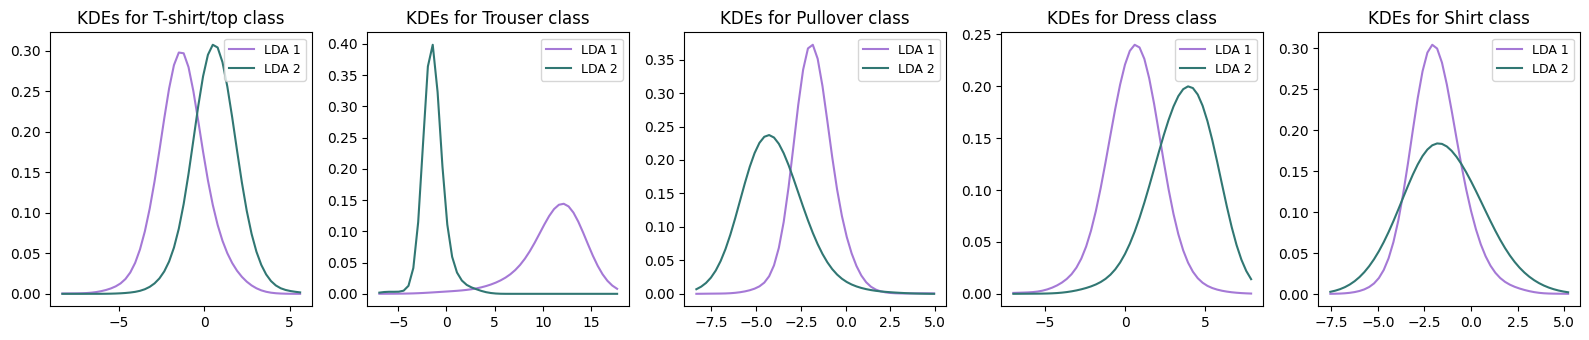

In [13]:
# Plotting kde for naive bayes with bandwidth 0.6.
colors = ['#A579D6', '#317773']
feature_labels = {0: "LDA 1", 1: "LDA 2"}
nbclf_chosen.plot_KDEs(LDA_X_train[:,:2], y_train, CLOTHING_TYPES, feature_labels, colors)

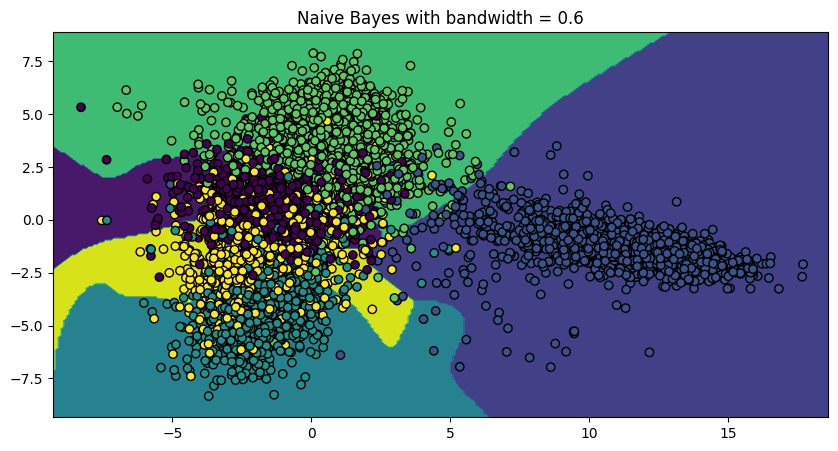

In [14]:
# plotting decision regions for naive bayes with bandwidth 0.6
# We can also plot the decision regions

fig,ax = plt.subplots(nrows=1,ncols=1, figsize=(10,5))

# Courseness of contourplot.  
h = 0.1

x_min, x_max = np.min(LDA_X_train[:,0])-1, np.max(LDA_X_train[:,0]) + 1
y_min, y_max = np.min(LDA_X_train[:,1])-1, np.max(LDA_X_train[:,1]) + 1

xx,yy = np.meshgrid(np.arange(x_min, x_max, h),
                    np.arange(y_min, y_max, h))

Z = nbclf_chosen.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

ax.contourf(xx,yy, Z)
ax.scatter(LDA_X_train[:,0],LDA_X_train[:,1], c=y_train, marker='o', edgecolor='black')
ax.set_xlim(xx.min(), xx.max());
ax.set_ylim(yy.min(), yy.max());
ax.set_title(f"Naive Bayes with bandwidth = 0.6");


# Naive Bayes Sklearn Implementation

We would like to compare our implementation to the naive bayes implementation of sklearn. To do this, we plot the decision regions of sklearn, and compare the performance metrics.



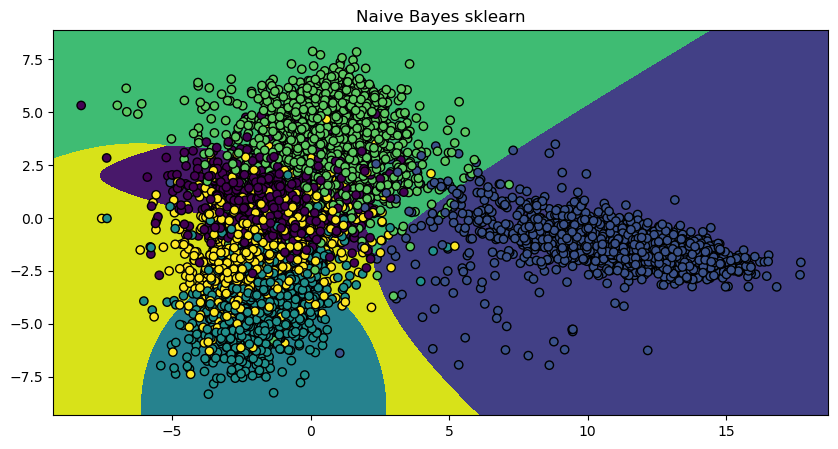

In [98]:
# plotting decision regions
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB().fit(LDA_X_train[:,:2],y_train)


fig,ax = plt.subplots(nrows=1,ncols=1, figsize=(10,5))

# Courseness of contourplot.  
h = 0.002

x_min, x_max = np.min(LDA_X_train[:,0])-1, np.max(LDA_X_train[:,0]) + 1
y_min, y_max = np.min(LDA_X_train[:,1])-1, np.max(LDA_X_train[:,1]) + 1

xx,yy = np.meshgrid(np.arange(x_min, x_max, h),
                    np.arange(y_min, y_max, h))

Z = nb.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

ax.contourf(xx,yy, Z)
ax.scatter(LDA_X_train[:,0],LDA_X_train[:,1], c=y_train, marker='o', edgecolor='black')
ax.set_xlim(xx.min(), xx.max());
ax.set_ylim(yy.min(), yy.max());
ax.set_title(f"Naive Bayes sklearn");



In [88]:
# comparing metrics

print(classification_report(y_true=y_test, y_pred=nb.predict(LDA_X_test[:,:2]), target_names=CLOTHING_TYPES.values()))

              precision    recall  f1-score   support

 T-shirt/top       0.59      0.73      0.66      1000
     Trouser       0.98      0.95      0.96      1000
    Pullover       0.70      0.79      0.74      1000
       Dress       0.80      0.81      0.80      1000
       Shirt       0.52      0.34      0.41      1000

    accuracy                           0.72      5000
   macro avg       0.72      0.72      0.71      5000
weighted avg       0.72      0.72      0.71      5000



Even though the two methods have different decision regions, we still get roughly the same metrics. We believe the decision regions are different, because the sklearn implementation is using a parametric method, whereas we use a non-parametric method. 